In [67]:
# Data Set voorbereiden
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import pyodbc
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

DB = {"servername": "localhost\SQLEXPRESS",
      "database": "greatoutdoors"}

export_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + 
                             ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')

export_cursor = export_conn.cursor()


orders = pd.read_sql_query("SELECT * FROM orders;", export_conn)
products = pd.read_sql_query("SELECT * FROM Product;", export_conn)
product_type = pd.read_sql_query("SELECT * FROM product_type;", export_conn)
order_method = pd.read_sql_query("SELECT * FROM order_method;", export_conn)
country = pd.read_sql_query("SELECT * FROM country;", export_conn)

retailer_site = pd.read_sql_query("SELECT * FROM retailer_site;", export_conn)

orders = orders.merge(right=products, how="inner", left_on= "order_detail_product_number",right_on="PRODUCT_NUMBER").merge(right=product_type, how='inner', on="PRODUCT_TYPE_CODE").merge(right=retailer_site, how='inner', left_on="retailer_site_code", right_on="RETAILER_SITE_CODE").merge(order_method, left_on="order_method_code", right_on="order_method_code", how="inner").merge(country,left_on="RETAILER_SITE_COUNTRY_code", right_on="COUNTRY_CODE", how="inner")
# p = pd.merge(left=orders, right=retailer_site, left_on="retailer_site_code", right_on="RETAILER_SITE_code", how="inner")
product_quantities_yearly = orders.groupby(['order_year', 'order_detail_product_number', 'order_detail_unit_cost', 'order_detail_unit_sale_price', 'order_detail_unit_price', "MARGIN_NUMBER", "PRODUCTION_COST_NUMBER", "PRODUCT_TYPE_EN", "RETAILER_TYPE_EN", "PRODUCT_LINE_NAME", "RETAILER_SITE_CITY_name", "RETAILER_SITE_REGION_name", "order_method_name", "COUNTRY_EN"])['order_detail_quantity'].sum().reset_index()

product_quantities_yearly.columns = ['Order Year', 'Product Number', 'order_detail_unit_cost', 'order_detail_unit_sale_price', 'order_detail_unit_price', "MARGIN_NUMBER", "PRODUCTION_COST_NUMBER", "PRODUCT_TYPE_EN", "RETAILER_TYPE_EN", "PRODUCT_LINE_NAME", "RETAILER_SITE_CITY_name", "RETAILER_SITE_REGION_name", "order_method_name", "COUNTRY_EN", 'Total Quantity Sold']

dummies_frame = pd.get_dummies(product_quantities_yearly.loc[:, ['PRODUCT_TYPE_EN', 'RETAILER_TYPE_EN', "PRODUCT_LINE_NAME", "RETAILER_SITE_CITY_name", "RETAILER_SITE_REGION_name" ,"order_method_name", "COUNTRY_EN"]])

product_quantities_yearly = pd.concat([product_quantities_yearly, dummies_frame], axis=1)

product_quantities_yearly = product_quantities_yearly.drop(["PRODUCT_TYPE_EN", "RETAILER_TYPE_EN", "PRODUCT_LINE_NAME", "RETAILER_SITE_CITY_name", "RETAILER_SITE_REGION_name","order_method_name", "COUNTRY_EN"], axis=1)


# # pd.set_option('max_row', None)
pd.set_option('display.max_rows', 1000)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_columns', 90)

# # Afhankelijk - wat we willen voorspellen
# # Onafhankelijk - op basis van wat we willen voorspellen



# # X_train = Kolommen waarop je wilt trainen
# # X_test = Kolommen zoals x train

# # Y train = Resultaat die je wilt voorspellen
# # Y_test = Resultaat zoals y train

X = product_quantities_yearly.drop('Total Quantity Sold', axis=1)
y = product_quantities_yearly.loc[:, ['Total Quantity Sold']]



# pd.get_option('display.max_rows')

# X
# y
# product_quantities_yearly # Onze dataset!
product_quantities_yearly.columns
# orders
# dummies_frame

Index(['Order Year', 'Product Number', 'order_detail_unit_cost',
       'order_detail_unit_sale_price', 'order_detail_unit_price',
       'MARGIN_NUMBER', 'PRODUCTION_COST_NUMBER', 'Total Quantity Sold',
       'PRODUCT_TYPE_EN_Binoculars', 'PRODUCT_TYPE_EN_Climbing Accessories',
       'PRODUCT_TYPE_EN_Cooking Gear', 'PRODUCT_TYPE_EN_Eyewear',
       'PRODUCT_TYPE_EN_First Aid', 'PRODUCT_TYPE_EN_Golf Accessories',
       'PRODUCT_TYPE_EN_Insect Repellents', 'PRODUCT_TYPE_EN_Irons',
       'PRODUCT_TYPE_EN_Knives', 'PRODUCT_TYPE_EN_Lanterns',
       'PRODUCT_TYPE_EN_Navigation', 'PRODUCT_TYPE_EN_Packs',
       'PRODUCT_TYPE_EN_Putters', 'PRODUCT_TYPE_EN_Rope',
       'PRODUCT_TYPE_EN_Safety', 'PRODUCT_TYPE_EN_Sleeping Bags',
       'PRODUCT_TYPE_EN_Sunscreen', 'PRODUCT_TYPE_EN_Tents',
       'PRODUCT_TYPE_EN_Tools', 'PRODUCT_TYPE_EN_Watches',
       'PRODUCT_TYPE_EN_Woods', 'RETAILER_TYPE_EN_Department Store',
       'RETAILER_TYPE_EN_Direct Marketing',
       'RETAILER_TYPE_EN_Equipme

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.15,
    random_state = 42
)
X_train
# y_test

,Order Year,Product Number,order_detail_unit_cost,order_detail_unit_sale_price,order_detail_unit_price,MARGIN_NUMBER,PRODUCTION_COST_NUMBER,PRODUCT_TYPE_EN_Binoculars,PRODUCT_TYPE_EN_Climbing Accessories,PRODUCT_TYPE_EN_Cooking Gear,PRODUCT_TYPE_EN_Eyewear,PRODUCT_TYPE_EN_First Aid,PRODUCT_TYPE_EN_Golf Accessories,PRODUCT_TYPE_EN_Insect Repellents,PRODUCT_TYPE_EN_Irons,PRODUCT_TYPE_EN_Knives,PRODUCT_TYPE_EN_Lanterns,PRODUCT_TYPE_EN_Navigation,PRODUCT_TYPE_EN_Packs,PRODUCT_TYPE_EN_Putters,PRODUCT_TYPE_EN_Rope,PRODUCT_TYPE_EN_Safety,PRODUCT_TYPE_EN_Sleeping Bags,PRODUCT_TYPE_EN_Sunscreen,PRODUCT_TYPE_EN_Tents,PRODUCT_TYPE_EN_Tools,PRODUCT_TYPE_EN_Watches,PRODUCT_TYPE_EN_Woods,RETAILER_TYPE_EN_Department Store,RETAILER_TYPE_EN_Direct Marketing,RETAILER_TYPE_EN_Equipment Rental Store,RETAILER_TYPE_EN_Eyewear Store,RETAILER_TYPE_EN_Golf Shop,RETAILER_TYPE_EN_Outdoors Shop,RETAILER_TYPE_EN_Sports Store,RETAILER_TYPE_EN_Warehouse Store,PRODUCT_LINE_NAME_Camping Equipment,PRODUCT_LINE_NAME_Golf Equipment,PRODUCT_LINE_NAME_Mountaineering Equipment,PRODUCT_LINE_NAME_Outdoor Protection,PRODUCT_LINE_NAME_Personal Accessories,RETAILER_SITE_CITY_name_Aarhus,RETAILER_SITE_CITY_name_Albany,RETAILER_SITE_CITY_name_Albuquerque,RETAILER_SITE_CITY_name_Alexandria,...,RETAILER_SITE_REGION_name_Tennessee,RETAILER_SITE_REGION_name_Texas,RETAILER_SITE_REGION_name_Thuringen,RETAILER_SITE_REGION_name_Tokyo,RETAILER_SITE_REGION_name_Utah,RETAILER_SITE_REGION_name_VIC,RETAILER_SITE_REGION_name_Vermont,RETAILER_SITE_REGION_name_Virginia,RETAILER_SITE_REGION_name_Vizcaya,RETAILER_SITE_REGION_name_Washington,RETAILER_SITE_REGION_name_West Midlands,RETAILER_SITE_REGION_name_West Virginia,RETAILER_SITE_REGION_name_Wisconsin,RETAILER_SITE_REGION_name_Wyoming,RETAILER_SITE_REGION_name_Yukon,RETAILER_SITE_REGION_name_Zaragoza,RETAILER_SITE_REGION_name_Zhejiang,order_method_name_E-mail,order_method_name_Fax,order_method_name_Mail,order_method_name_Sales visit,order_method_name_Special,order_method_name_Telephone,order_method_name_Web,COUNTRY_EN_Australia,COUNTRY_EN_Austria,COUNTRY_EN_Belgium,COUNTRY_EN_Brazil,COUNTRY_EN_Canada,COUNTRY_EN_China,COUNTRY_EN_Denmark,COUNTRY_EN_Finland,COUNTRY_EN_France,COUNTRY_EN_Germany,COUNTRY_EN_Italy,COUNTRY_EN_Japan,COUNTRY_EN_Korea,COUNTRY_EN_Mexico,COUNTRY_EN_Netherlands,COUNTRY_EN_Spain,COUNTRY_EN_Sweden,COUNTRY_EN_Switzerland,COUNTRY_EN_Taiwan,COUNTRY_EN_United Kingdom,COUNTRY_EN_United States
11072,2021,14,489.42,585.28,611.78,0.20,476,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
32962,2022,60,10.00,20.00,20.00,0.50,10,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3923,2020,63,32.59,48.88,48.88,0.33,30,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,F

In [70]:
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(X_train, y_train)

reg_model

LinearRegression()

In [72]:
y_pred = reg_model.predict(X_test)
y_pred

array([[ 35.33001423],
       [ 52.91821027],
       [138.45717025],
       ...,
       [ 51.87338233],
       [ 22.91740799],
       [ 44.34901094]])

In [73]:
prediction_df = pd.DataFrame(y_pred)

prediction_df = prediction_df.rename(columns = {0 : "Voorspelde Verkoopcijfers"})

prediction_df

,Voorspelde Verkoopcijfers
0,35.330014
1,52.918210
2,138.457170
3,39.524630
4,1.237122
...,...
5993,18.016680
5994,22.169991
5995,51.873382
5996,22.917408


In [74]:
pd.set_option('display.max_rows', 10)
pd.set_option("max_colwidth", None)
pd.set_option("max_seq_items", None)
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
y_test_prediction_merge = pd.concat([y_test.reset_index()['Total Quantity Sold'], prediction_df], axis = 1)
y_test_prediction_merge.loc[y_test_prediction_merge['Voorspelde Verkoopcijfers'].notna(), :]

,Total Quantity Sold,Voorspelde Verkoopcijfers
0,24,35.330014
1,40,52.918210
2,120,138.457170
3,76,39.524630
4,4,1.237122
5,28,60.431701
6,36,49.183799
7,82,76.461869
8,22,24.267952
9,26,40.600591


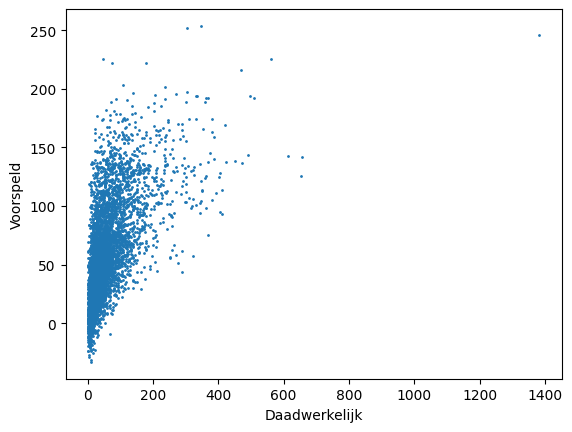

In [75]:
# plt.xticks([0, 10, 20, 30, 40, 50, 60 ,70 ,80, 90, 100])
plt.scatter(y_test_prediction_merge['Total Quantity Sold'], y_test_prediction_merge['Voorspelde Verkoopcijfers'],s=1)

plt.xlabel('Daadwerkelijk')
plt.ylabel('Voorspeld')
plt.show()

In [76]:
mean_squared_error(y_test_prediction_merge['Total Quantity Sold'], y_test_prediction_merge['Voorspelde Verkoopcijfers'])


2290.009049313481

In [77]:
mean_absolute_error(y_test_prediction_merge['Total Quantity Sold'], y_test_prediction_merge['Voorspelde Verkoopcijfers'])

28.451230592749923

In [78]:
mean_absolute_percentage_error(y_test_prediction_merge['Total Quantity Sold'], y_test_prediction_merge['Voorspelde Verkoopcijfers'])

0.9399788212000654